In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. Load the datasets
payroll_df = pd.read_csv('sample_payroll.csv')
timekeeping_df = pd.read_csv('sample_timekeeping.csv')

# 2. Convert datetime columns to proper datetime objects
datetime_columns = ['punchin1', 'punchout1', 'punchin2', 'punchout2', 'punchin3', 'punchout3']
for col in datetime_columns:
    timekeeping_df[col] = pd.to_datetime(timekeeping_df[col], errors='coerce')

# Convert date column to datetime
timekeeping_df['date'] = pd.to_datetime(timekeeping_df['date'], errors='coerce')

# 3. Extract time components - this is more efficient
timekeeping_df['break1_start_hour'] = timekeeping_df['punchout1'].dt.hour
timekeeping_df['break1_start_minute'] = timekeeping_df['punchout1'].dt.minute
timekeeping_df['break1_start_time'] = timekeeping_df['break1_start_hour'] + timekeeping_df['break1_start_minute']/60

# Extract day-of-week for analysis
timekeeping_df['day_of_week'] = timekeeping_df['date'].dt.day_name()
timekeeping_df['day_of_week_num'] = timekeeping_df['date'].dt.dayofweek

# 4. OPTIMIZED APPROACH: Analyze hourly break patterns
# Round break start times to the nearest hour for simpler analysis
timekeeping_df['break_hour_rounded'] = timekeeping_df['punchout1'].dt.floor('H')

# Count breaks by hour, day, and department
break_hour_counts = timekeeping_df.groupby(['break_hour_rounded', 'department']).size().reset_index(name='break_count')

# 5. Find peak break hours by department
dept_peak_hours = break_hour_counts.sort_values('break_count', ascending=False).groupby('department').head(1)
print("\nPeak Break Hours by Department:")
print(dept_peak_hours[['department', 'break_hour_rounded', 'break_count']])

/var/folders/0b/kbxw3yp15078rb4blsyr1khw0000gn/T/ipykernel_72527/1736577774.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  timekeeping_df[col] = pd.to_datetime(timekeeping_df[col], errors='coerce')
/var/folders/0b/kbxw3yp15078rb4blsyr1khw0000gn/T/ipykernel_72527/1736577774.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  timekeeping_df[col] = pd.to_datetime(timekeeping_df[col], errors='coerce')
/var/folders/0b/kbxw3yp15078rb4blsyr1khw0000gn/T/ipykernel_72527/1736577774.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  timekeeping_df[col] = pd.to_datetime(timeke


Peak Break Hours by Department:
                      department  break_hour_rounded  break_count
2428    RESEARCH AND DEVELOPMENT 2023-08-04 12:00:00            6
2420                   WAREHOUSE 2023-08-02 12:00:00            4
477                        SALES 2022-01-21 11:00:00            3
3972  LOGISTICS AND DISTRIBUTION 2024-08-12 11:00:00            3
3132            CUSTOMER SERVICE 2024-02-06 12:00:00            3
1892                   MARKETING 2023-03-14 12:00:00            2
3738             QUALITY CONTROL 2024-06-20 11:00:00            2
3045                 PROCUREMENT 2024-01-12 12:00:00            1
2929                 MAINTENANCE 2023-12-12 12:00:00            1
2962                       OTHER 2023-12-21 12:00:00            1
3056              ADMINISTRATION 2024-01-16 12:00:00            1
4181               IT DEPARTMENT 2024-09-25 12:00:00            1


In [2]:
# 6. Calculate department size for percentage analysis
dept_sizes = timekeeping_df.groupby('department')['employee_id'].nunique().reset_index()
dept_sizes.columns = ['department', 'total_employees']

# 7. Merge to get percentages
peak_break_analysis = pd.merge(dept_peak_hours, dept_sizes, on='department', how='left')
peak_break_analysis['pct_on_break'] = (peak_break_analysis['break_count'] / peak_break_analysis['total_employees'] * 100).round(1)

# Sort by percentage for most impacted departments
peak_break_analysis = peak_break_analysis.sort_values('pct_on_break', ascending=False)
print("\nDepartments Most Impacted by Break Synchronization:")
print(peak_break_analysis[['department', 'break_hour_rounded', 'break_count', 'total_employees', 'pct_on_break']])

# 8. Break synchronization across organization
# Group by hour and sum all breaks
org_break_pattern = break_hour_counts.groupby('break_hour_rounded')['break_count'].sum().reset_index()
org_break_pattern = org_break_pattern.sort_values('break_count', ascending=False)
print("\nOrganization-wide Break Patterns:")
print(org_break_pattern.head(5))

# 9. Break distribution by day of week
day_break_pattern = timekeeping_df.groupby(['day_of_week', 'break1_start_hour']).size().reset_index(name='count')
day_peak_hours = day_break_pattern.sort_values('count', ascending=False).groupby('day_of_week').head(1)
print("\nPeak Break Hours by Day of Week:")
print(day_peak_hours)


Departments Most Impacted by Break Synchronization:
                    department  break_hour_rounded  break_count  \
5                    MARKETING 2023-03-14 12:00:00            2   
7                  PROCUREMENT 2024-01-12 12:00:00            1   
8                  MAINTENANCE 2023-12-12 12:00:00            1   
9                        OTHER 2023-12-21 12:00:00            1   
10              ADMINISTRATION 2024-01-16 12:00:00            1   
11               IT DEPARTMENT 2024-09-25 12:00:00            1   
4             CUSTOMER SERVICE 2024-02-06 12:00:00            3   
0     RESEARCH AND DEVELOPMENT 2023-08-04 12:00:00            6   
3   LOGISTICS AND DISTRIBUTION 2024-08-12 11:00:00            3   
1                    WAREHOUSE 2023-08-02 12:00:00            4   
6              QUALITY CONTROL 2024-06-20 11:00:00            2   
2                        SALES 2022-01-21 11:00:00            3   

    total_employees  pct_on_break  
5                 2         100.0  
7  


Hours with Highest Cross-Department Break Overlap:
                   hour                                        departments  \
526 2023-02-08 12:00:00  [CUSTOMER SERVICE, LOGISTICS AND DISTRIBUTION,...   
784 2023-10-04 12:00:00  [CUSTOMER SERVICE, LOGISTICS AND DISTRIBUTION,...   
512 2023-01-26 12:00:00  [MAINTENANCE, MARKETING, PROCUREMENT, RESEARCH...   
581 2023-03-27 12:00:00  [CUSTOMER SERVICE, LOGISTICS AND DISTRIBUTION,...   
709 2023-07-28 12:00:00  [CUSTOMER SERVICE, LOGISTICS AND DISTRIBUTION,...   

     dept_count  total_breaks  
526           7           9.0  
784           6          10.0  
512           6           9.0  
581           6           8.0  
709           6           7.0  


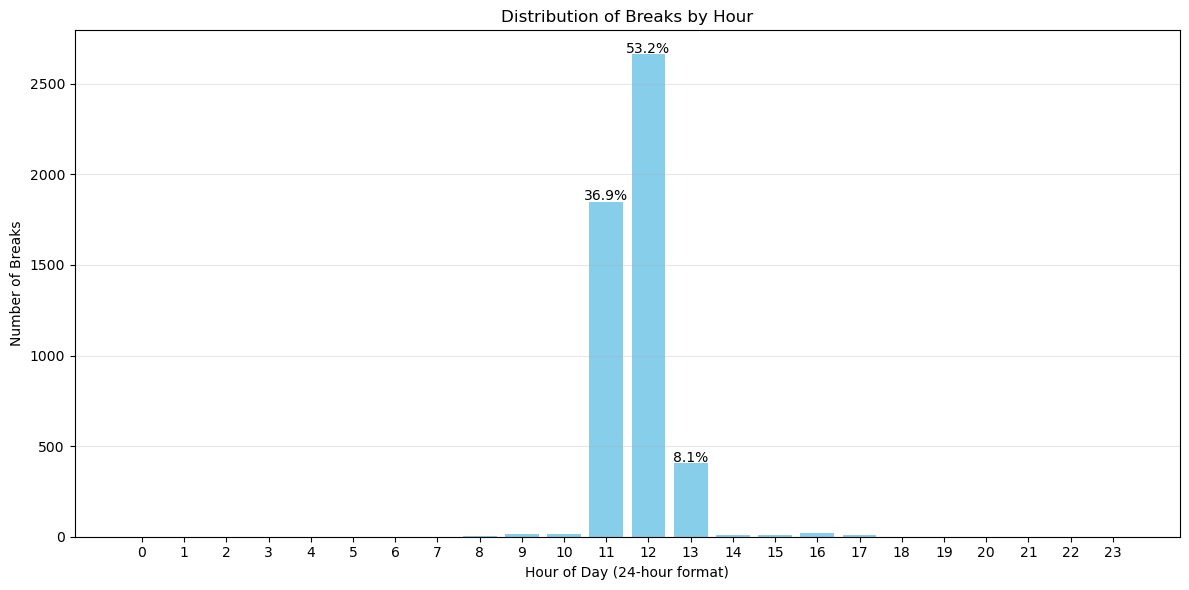

In [3]:
# 10. Visualize break distribution by hour
plt.figure(figsize=(12, 6))
hours = range(24)
break_by_hour = timekeeping_df.groupby('break1_start_hour').size()
break_counts = [break_by_hour.get(hour, 0) for hour in hours]

plt.bar(hours, break_counts, color='skyblue')
plt.title('Distribution of Breaks by Hour')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Breaks')
plt.xticks(hours)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels
total_breaks = sum(break_counts)
for i, count in enumerate(break_counts):
    if count > 0:
        pct = count / total_breaks * 100
        if pct > 5:  # Only show percentages for significant hours
            plt.text(i, count + 10, f"{pct:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('break_hour_distribution.png')

# 11. Break overlap analysis by department
# Calculate the hours with highest break overlap
dept_hour_matrix = break_hour_counts.pivot(index='department', columns='break_hour_rounded', values='break_count').fillna(0)

# Find hours with breaks from multiple departments
overlap_hours = []
for col in dept_hour_matrix.columns:
    depts_with_breaks = dept_hour_matrix[dept_hour_matrix[col] > 0].index.tolist()
    if len(depts_with_breaks) > 1:
        overlap_hours.append({
            'hour': col,
            'departments': depts_with_breaks,
            'dept_count': len(depts_with_breaks),
            'total_breaks': dept_hour_matrix[col].sum()
        })

overlap_df = pd.DataFrame(overlap_hours)
if not overlap_df.empty:
    overlap_df = overlap_df.sort_values(['dept_count', 'total_breaks'], ascending=False)
    print("\nHours with Highest Cross-Department Break Overlap:")
    print(overlap_df.head(5))


In [5]:
# 12. Business implications
print("\n===== BUSINESS IMPLICATIONS =====")

# Find departments with high break synchronization
high_sync_depts = peak_break_analysis[peak_break_analysis['pct_on_break'] > 25]
if not high_sync_depts.empty:
    print("\nSTAFFING RISK ALERT: Departments with >25% of staff on break simultaneously:")
    for _, row in high_sync_depts.iterrows():
        print(f"  {row['department']}: {row['pct_on_break']}% of staff on break at {row['break_hour_rounded']}")




===== BUSINESS IMPLICATIONS =====

STAFFING RISK ALERT: Departments with >25% of staff on break simultaneously:
  MARKETING: 100.0% of staff on break at 2023-03-14 12:00:00
  PROCUREMENT: 100.0% of staff on break at 2024-01-12 12:00:00
  MAINTENANCE: 100.0% of staff on break at 2023-12-12 12:00:00
  OTHER: 100.0% of staff on break at 2023-12-21 12:00:00
  ADMINISTRATION: 100.0% of staff on break at 2024-01-16 12:00:00
  IT DEPARTMENT: 100.0% of staff on break at 2024-09-25 12:00:00
  CUSTOMER SERVICE: 75.0% of staff on break at 2024-02-06 12:00:00
  RESEARCH AND DEVELOPMENT: 66.7% of staff on break at 2023-08-04 12:00:00
  LOGISTICS AND DISTRIBUTION: 60.0% of staff on break at 2024-08-12 11:00:00
  WAREHOUSE: 50.0% of staff on break at 2023-08-02 12:00:00
  QUALITY CONTROL: 50.0% of staff on break at 2024-06-20 11:00:00
  SALES: 37.5% of staff on break at 2022-01-21 11:00:00


In [6]:
# Check if breaks are clustered at specific hours
if not org_break_pattern.empty:
    top_hours = org_break_pattern.head(3)
    total_breaks = org_break_pattern['break_count'].sum()
    top_hours_pct = top_hours['break_count'].sum() / total_breaks * 100
    
    print(f"\nBreak Clustering: {top_hours_pct:.1f}% of all breaks occur during just {len(top_hours)} peak hours")
    for _, row in top_hours.iterrows():
        hour_pct = row['break_count'] / total_breaks * 100
        print(f"  {row['break_hour_rounded'].hour}:00 - {row['break_count']} breaks ({hour_pct:.1f}% of all breaks)")

# Day of week patterns
if not day_peak_hours.empty:
    print("\nDay-of-Week Patterns:")
    for _, row in day_peak_hours.iterrows():
        print(f"  {row['day_of_week']}: Peak break hour at {row['break1_start_hour']}:00 with {row['count']} breaks")

# Department overlap implications
if not overlap_df.empty and len(overlap_df) > 0:
    max_overlap = overlap_df.iloc[0]
    print(f"\nCritical Overlap Period: {max_overlap['hour'].hour}:00 has {max_overlap['dept_count']} departments with breaks simultaneously")
    print(f"  Departments affected: {', '.join(max_overlap['departments'])}")

print("\nRecommendations for Break Scheduling:")
print("1. Stagger breaks for departments with highest synchronization percentages")
print("2. Consider creating A/B break groups in large departments like Warehouse and Research")
print("3. Adjust scheduling to reduce cross-departmental overlap during peak hours")
print("4. Implement 'break coverage' roles during high-impact hours")


Break Clustering: 0.6% of all breaks occur during just 3 peak hours
  12:00 - 10 breaks (0.2% of all breaks)
  12:00 - 10 breaks (0.2% of all breaks)
  12:00 - 9 breaks (0.2% of all breaks)

Day-of-Week Patterns:
  Wednesday: Peak break hour at 12:00 with 550 breaks
  Thursday: Peak break hour at 12:00 with 540 breaks
  Friday: Peak break hour at 12:00 with 528 breaks
  Tuesday: Peak break hour at 12:00 with 521 breaks
  Monday: Peak break hour at 12:00 with 504 breaks
  Saturday: Peak break hour at 12:00 with 13 breaks
  Sunday: Peak break hour at 12:00 with 6 breaks

Critical Overlap Period: 12:00 has 7 departments with breaks simultaneously
  Departments affected: CUSTOMER SERVICE, LOGISTICS AND DISTRIBUTION, MARKETING, OTHER, RESEARCH AND DEVELOPMENT, SALES, WAREHOUSE

Recommendations for Break Scheduling:
1. Stagger breaks for departments with highest synchronization percentages
2. Consider creating A/B break groups in large departments like Warehouse and Research
3. Adjust sched